<a href="https://colab.research.google.com/github/Auvarmf/Riset-MBKM-CNN2023/blob/main/Modelv4_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tqdm import tqdm
import shutil
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate
from google.colab import drive

In [2]:
# Mount Google Drive to access files and folders
drive.mount('/content/MBKMCNN')

Drive already mounted at /content/MBKMCNN; to attempt to forcibly remount, call drive.mount("/content/MBKMCNN", force_remount=True).


In [3]:
# Define the base directory where all images are stored
BASE_DIR = '/content/MBKMCNN/MyDrive/MBKMCNN/datasetv2_inception'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'testing')

class_names = os.listdir(train_dir)

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMG_SIZE = (64, 64)

In [4]:
def load_data(directory):
    images = []
    labels = []

    for folder in os.listdir(directory):
        if folder in class_names:
            label = class_names.index(folder)

            for file in os.listdir(os.path.join(directory, folder)):
                img_path = os.path.join(os.path.join(directory, folder), file)

                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp')):
                    image = cv2.imread(img_path)

                    if image is not None:
                        image = cv2.resize(image, IMG_SIZE)
                        images.append(image)
                        labels.append(label)

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")

    # Shuffle the data using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=25)

    return images, labels

In [5]:
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [7]:
def display_examples(class_names, images, labels):
    figsize = (20, 20)
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Contoh Sampel Dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]])
    plt.show()

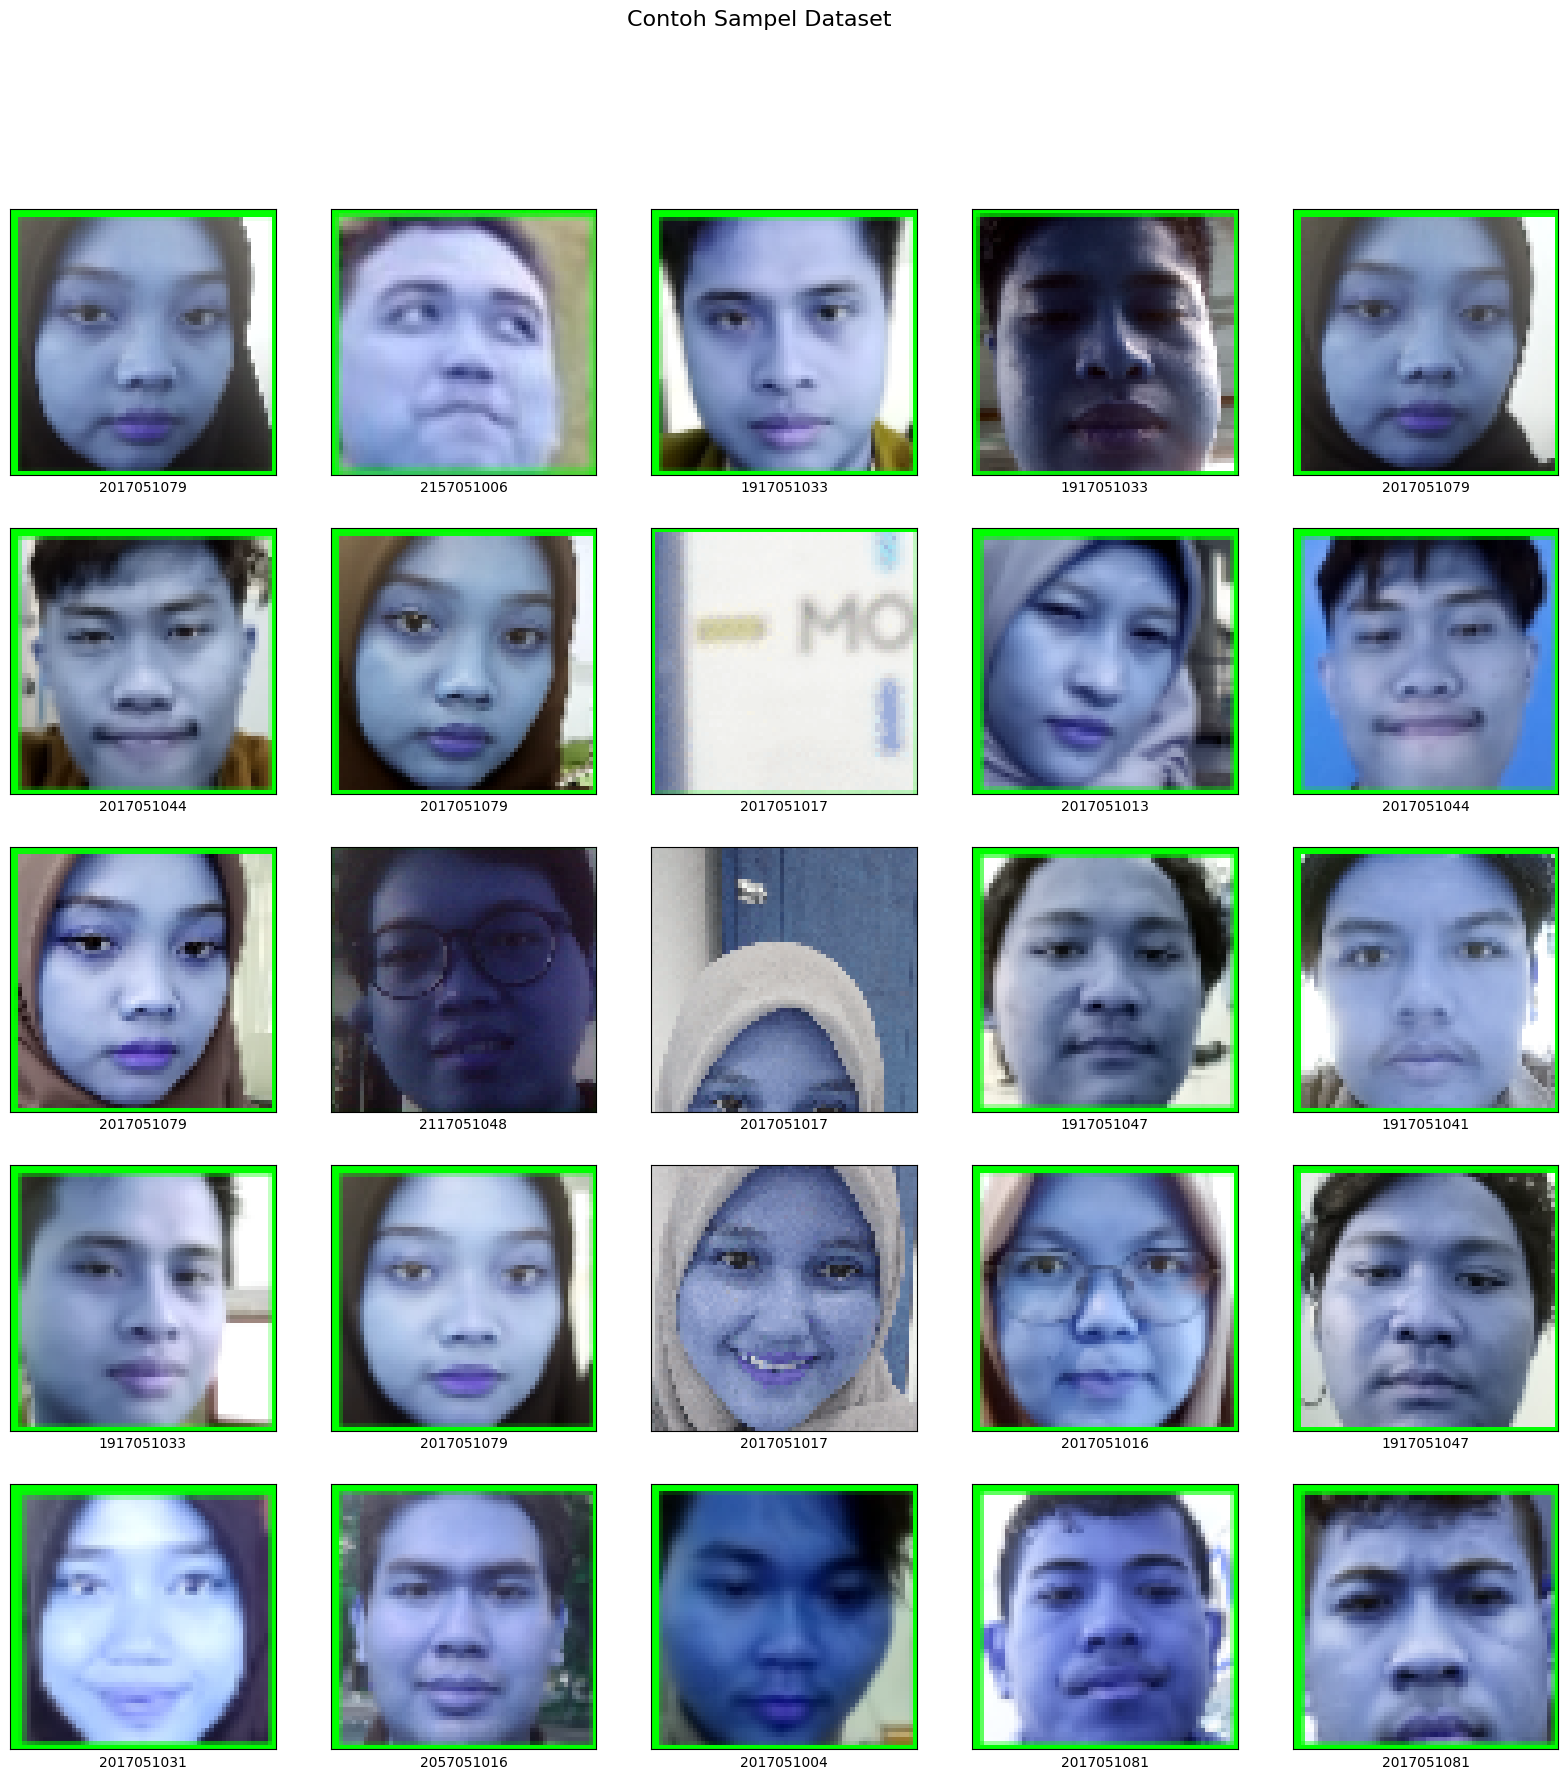

In [8]:
display_examples(class_names, train_images, train_labels)

In [9]:
train_data = ImageDataGenerator(rescale=1/255)
validation_data = ImageDataGenerator(rescale=1/255)

In [10]:
train_dataset = train_data.flow_from_directory(train_dir,
                                               target_size=IMG_SIZE,
                                               batch_size=32,
                                               class_mode='sparse')

validation_dataset = validation_data.flow_from_directory(val_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=32,
                                                         class_mode='sparse')

test_dataset = validation_data.flow_from_directory(test_dir,
                                                   target_size=IMG_SIZE,
                                                   batch_size=32,
                                                   class_mode='sparse')

Found 497 images belonging to 25 classes.
Found 497 images belonging to 25 classes.
Found 497 images belonging to 25 classes.


In [11]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_in, (1, 1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3, 3), padding='same', activation='relu')(conv3)
    conv5 = Conv2D(f3_in, (1, 1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5, 5), padding='same', activation='relu')(conv5)
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1, 1), padding='same', activation='relu')(pool)
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [12]:
visible = Input(shape=(*IMG_SIZE, 3))
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
output = Dense(nb_classes, activation='softmax')(layer)

model = Model(inputs=visible, outputs=output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 96)           384       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 64, 64, 16)           64        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 3)            0         ['input_1[0][0]']             
 D)                                                                                           

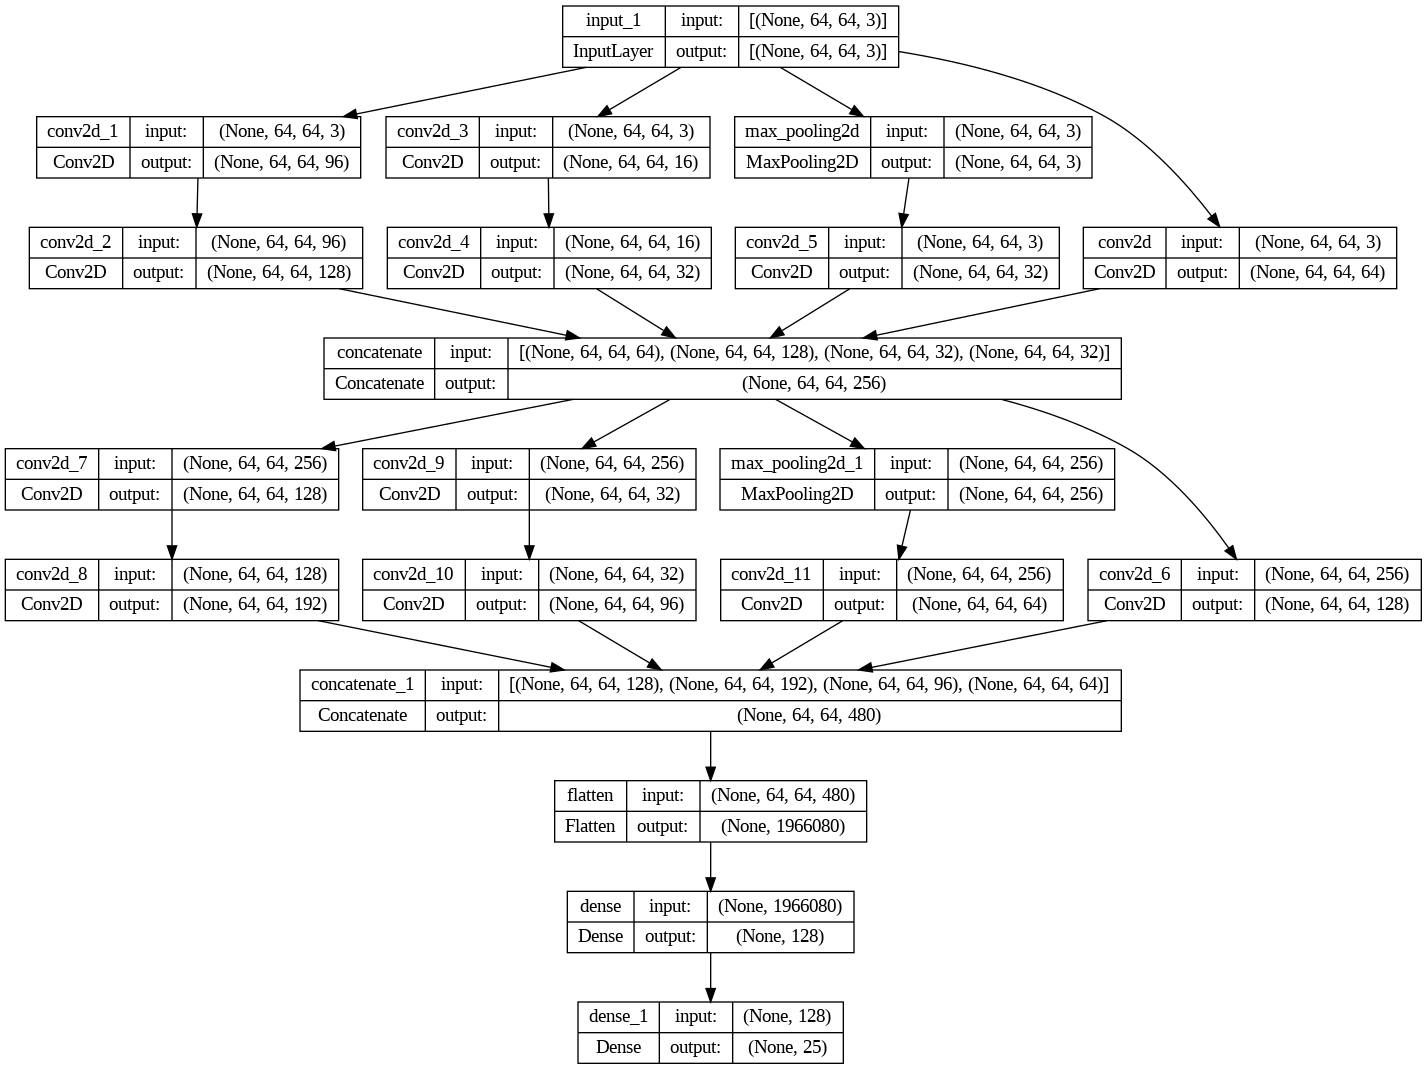

In [13]:
model.summary()

plot_model(model, show_shapes=True, to_file='inception_module.png')

In [14]:
# Reduce batch size and add regularizer
train_data = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
16/16 [==============================] - 348s 22s/step - loss: 28.1476 - accuracy: 0.1308 - val_loss: 2.4661 - val_accuracy: 0.3360
Epoch 2/10
16/16 [==============================] - 348s 22s/step - loss: 2.0569 - accuracy: 0.4064 - val_loss: 1.2958 - val_accuracy: 0.6942
Epoch 3/10
16/16 [==============================] - 330s 21s/step - loss: 1.1654 - accuracy: 0.6841 - val_loss: 0.8360 - val_accuracy: 0.7787
Epoch 4/10
16/16 [==============================] - 337s 21s/step - loss: 0.8221 - accuracy: 0.7907 - val_loss: 0.5080 - val_accuracy: 0.8491
Epoch 5/10
16/16 [==============================] - 335s 21s/step - loss: 0.5997 - accuracy: 0.8330 - val_loss: 0.4713 - val_accuracy: 0.8753
Epoch 6/10
16/16 [==============================] - 328s 21s/step - loss: 0.4595 - accuracy: 0.8672 - val_loss: 0.3463 - val_accuracy: 0.9135
Epoch 7/10
16/16 [==============================] - 339s 22s/step - loss: 0.3105 - accuracy: 0.9074 - val_loss: 0.2170 - val_accuracy: 0.9416
Epoch

In [17]:
def plot_accuracy_loss(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Training & Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Training & Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

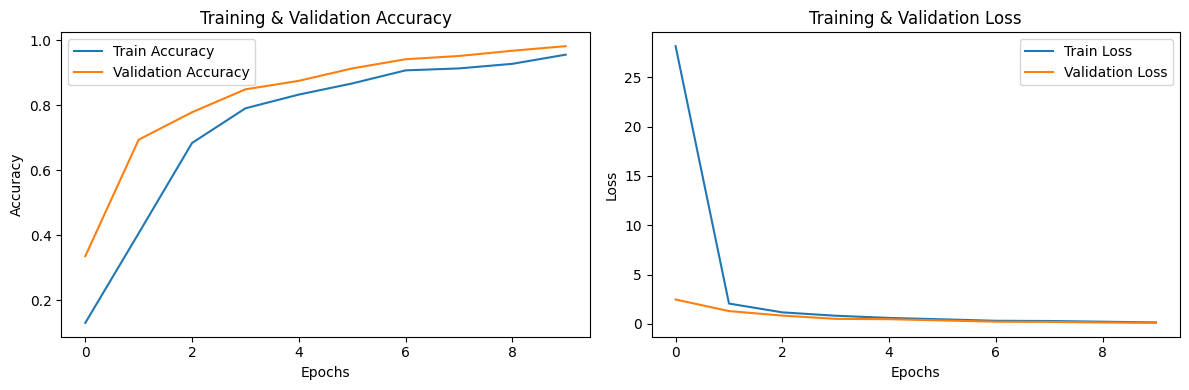

In [18]:
plot_accuracy_loss(history)

In [19]:
# Calculate accuracy on validation data
validation_loss, validation_accuracy = model.evaluate(validation_dataset)

16/16 [==============================] - 61s 4s/step - loss: 0.0982 - accuracy: 0.9819


In [20]:
# Calculate accuracy on testing data
test_loss, test_accuracy = model.evaluate(test_dataset)

16/16 [==============================] - 58s 4s/step - loss: 0.0982 - accuracy: 0.9819


In [21]:
print("Testing Accuracy: {:.2f}%".format(test_accuracy * 100))

Testing Accuracy: 98.19%


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 96)           384       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 64, 64, 16)           64        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 3)            0         ['input_1[0][0]']             
 D)                                                                                           